<a href="https://colab.research.google.com/github/Dewdiii/Forecasting-Industry-Growth-Based-on-Historical-Trade-Data-Exports-Imports-in-Sri-Lanka./blob/main/ImpExp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
from google.colab import files
uploaded = files.upload()  # Choose ImpExp.zip

Saving ImpExp.zip to ImpExp.zip


In [3]:
import zipfile
import os

with zipfile.ZipFile("ImpExp.zip", 'r') as zip_ref:
    zip_ref.extractall("data/")  # extracts to data/ImpExp/

In [4]:
industries = [
            'Agricultural Raw Materials',
            'Consumer Goods',
            'Transportation',
            'Food Industry',
            'Capital Goods'
            ]

model_dir = "models/ImpExp/{}"
data_dir = "data/ImpExp/{}"

## Build the Dataset

In [5]:
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

def load_industry_data(industry):
    # List all .xlsx files inside the industry-specific folder
    all_csvs = os.listdir(data_dir.format(industry))
    all_csvs = [f for f in all_csvs if f.endswith(".xlsx")]
    all_csv_paths = [os.path.join(data_dir.format(industry), f) for f in all_csvs]

    all_data = []
    for csv in all_csv_paths:
        df = pd.read_excel(csv, sheet_name='Partner')
        df['Partner Name'] = df['Partner Name'].str.strip()
        df = df[df['Partner Name'] == 'World']
        assert len(df) == 1, f"More than one or no 'World' data found in {csv}"

        df = df[[
            'Year',
            'Export (US$ Thousand)',
            'Import (US$ Thousand)',
            'Revealed comparative advantage',
            'World Growth (%)',
            'Country Growth (%)',
            'AHS Simple Average (%)',
            'AHS Dutiable Tariff Lines Share (%)',
        ]]
        df.reset_index(drop=True, inplace=True)
        all_data.append(df)

    # Combine all files
    all_data = pd.concat(all_data).reset_index(drop=True)

    # Fill missing values with column means
    all_data.fillna(all_data.mean(), inplace=True)
    all_data = all_data.astype(float)

    # Sort by year and remove the 'Year' column
    all_data.sort_values(by='Year', inplace=True)
    all_data.drop(columns=['Year'], inplace=True)

    # Fit and save the scaler
    scaler = StandardScaler()
    scaler.fit(all_data)

    # Create model directory if it doesn't exist
    os.makedirs(os.path.dirname(model_dir.format("")), exist_ok=True)

    with open(model_dir.format(f"{industry} Scalar.pickle"), 'wb') as f:
        pickle.dump(scaler, f)

    # Scale the data
    scaled_data = pd.DataFrame(scaler.transform(all_data), columns=all_data.columns)
    return scaled_data

def make_ts_dataset(industry, selective_window=7):
    df = load_industry_data(industry)

    X, Y1, Y2 = [], [], []
    for i in range(len(df) - selective_window):
        x = df.iloc[i:i+selective_window].values
        y1 = df.iloc[i+selective_window, 0]  # Export
        y2 = df.iloc[i+selective_window, 1]  # Import

        X.append(x)
        Y1.append(y1)
        Y2.append(y2)

    return np.array(X), np.array(Y1), np.array(Y2)


### Load Sample Data

In [6]:
X, Y1, Y2 = make_ts_dataset('Agricultural Raw Materials')

print("World Data Shape : ", X.shape)
print("Export Data Shape : ", Y1.shape)
print("Import Data Shape : ", Y2.shape)

World Data Shape :  (9, 7, 7)
Export Data Shape :  (9,)
Import Data Shape :  (9,)


In [20]:
import numpy as np
import pickle
from sklearn.metrics import mean_absolute_error, mean_squared_error

def get_growth_rate(predicted, last_actual):
    if last_actual == 0:
        return 0
    return ((predicted - last_actual) / last_actual) * 100

def baseline_training_evaluation(industry, window_size=3):
    # Load data and scaler
    df = load_industry_data(industry)  # assumed shape: [time_steps, 2] with columns [export, import]
    scaler = pickle.load(open(model_dir.format(f"{industry} Scalar.pickle"), 'rb'))

    # Undo scaling
    df_inv = scaler.inverse_transform(df)

    # Separate export and import series
    export_series = df_inv[:, 0]
    import_series = df_inv[:, 1]

    def evaluate_series(series, label):
        print(f"\n--- {label} ---")

        # Naive predictions: previous year's value (shifted by 1)
        naive_preds = series[:-1]
        naive_actuals = series[1:]

        # SMA predictions (window_size)
        sma_preds = []
        sma_actuals = []
        for i in range(window_size, len(series)):
            window = series[i-window_size:i]
            sma_preds.append(np.mean(window))
            sma_actuals.append(series[i])

        # Accuracy metrics
        naive_mae = mean_absolute_error(naive_actuals, naive_preds)
        naive_mse = mean_squared_error(naive_actuals, naive_preds)
        naive_rmse = np.sqrt(naive_mse)

        sma_mae = mean_absolute_error(sma_actuals, sma_preds)
        sma_mse = mean_squared_error(sma_actuals, sma_preds)
        sma_rmse = np.sqrt(sma_mse)

        print("Naïve Accuracy:")
        print(f"  MAE:  {naive_mae:.2f}")
        print(f"  MSE:  {naive_mse:.2f}")
        print(f"  RMSE: {naive_rmse:.2f}")

        print("SMA Accuracy:")
        print(f"  MAE:  {sma_mae:.2f}")
        print(f"  MSE:  {sma_mse:.2f}")
        print(f"  RMSE: {sma_rmse:.2f}")

        # Growth rate prediction
        last_actual = series[-2]  # last known actual value (second last)
        naive_pred = series[-2]   # naive prediction uses last actual
        sma_pred = np.mean(series[-window_size-1:-1])  # SMA with window_size

        naive_growth = get_growth_rate(naive_pred, last_actual)
        sma_growth = get_growth_rate(sma_pred, last_actual)

        print(f"Naive Predicted Growth: {naive_growth:.2f}%")
        print(f"SMA Predicted Growth:   {sma_growth:.2f}%")

    print(f"\n📊 Baseline Training Evaluation for Industry: {industry} (window={window_size})")

    evaluate_series(export_series, "Export")
    evaluate_series(import_series, "Import")

In [21]:
baseline_training_evaluation('Agricultural Raw Materials', window_size=3)


📊 Baseline Training Evaluation for Industry: Agricultural Raw Materials (window=3)

--- Export ---
Naïve Accuracy:
  MAE:  45766.05
  MSE:  2952697504.69
  RMSE: 54338.73
SMA Accuracy:
  MAE:  55336.34
  MSE:  4631915570.28
  RMSE: 68058.18
Naive Predicted Growth: 0.00%
SMA Predicted Growth:   -10.98%

--- Import ---
Naïve Accuracy:
  MAE:  53988.11
  MSE:  4708589783.71
  RMSE: 68619.16
SMA Accuracy:
  MAE:  72405.66
  MSE:  7534516973.21
  RMSE: 86801.60
Naive Predicted Growth: 0.00%
SMA Predicted Growth:   10.05%


In [22]:
baseline_training_evaluation('Consumer Goods', window_size=3)


📊 Baseline Training Evaluation for Industry: Consumer Goods (window=3)

--- Export ---
Naïve Accuracy:
  MAE:  720244.59
  MSE:  674797320163.76
  RMSE: 821460.48
SMA Accuracy:
  MAE:  748797.27
  MSE:  783966067576.76
  RMSE: 885418.58
Naive Predicted Growth: 0.00%
SMA Predicted Growth:   6.09%

--- Import ---
Naïve Accuracy:
  MAE:  947863.18
  MSE:  1247659704340.62
  RMSE: 1116986.89
SMA Accuracy:
  MAE:  866368.67
  MSE:  1284660347203.94
  RMSE: 1133428.58
Naive Predicted Growth: 0.00%
SMA Predicted Growth:   29.17%


In [23]:
baseline_training_evaluation('Transportation', window_size=3)


📊 Baseline Training Evaluation for Industry: Transportation (window=3)

--- Export ---
Naïve Accuracy:
  MAE:  75888.57
  MSE:  9614073131.04
  RMSE: 98051.38
SMA Accuracy:
  MAE:  69039.73
  MSE:  7272176443.70
  RMSE: 85277.06
Naive Predicted Growth: 0.00%
SMA Predicted Growth:   68.87%

--- Import ---
Naïve Accuracy:
  MAE:  435642.24
  MSE:  289278875556.66
  RMSE: 537846.52
SMA Accuracy:
  MAE:  525376.91
  MSE:  474184422661.87
  RMSE: 688610.50
Naive Predicted Growth: 0.00%
SMA Predicted Growth:   105.31%


In [24]:
baseline_training_evaluation('Food Industry', window_size=3)


📊 Baseline Training Evaluation for Industry: Food Industry (window=3)

--- Export ---
Naïve Accuracy:
  MAE:  48799.68
  MSE:  5101659887.93
  RMSE: 71425.90
SMA Accuracy:
  MAE:  80596.02
  MSE:  9853026810.03
  RMSE: 99262.41
Naive Predicted Growth: 0.00%
SMA Predicted Growth:   -6.08%

--- Import ---
Naïve Accuracy:
  MAE:  79635.03
  MSE:  9497381160.02
  RMSE: 97454.51
SMA Accuracy:
  MAE:  105556.13
  MSE:  17843026389.15
  RMSE: 133577.79
Naive Predicted Growth: 0.00%
SMA Predicted Growth:   1.83%


In [25]:
baseline_training_evaluation('Capital Goods', window_size=3)


📊 Baseline Training Evaluation for Industry: Capital Goods (window=3)

--- Export ---
Naïve Accuracy:
  MAE:  115110.24
  MSE:  17204406277.59
  RMSE: 131165.57
SMA Accuracy:
  MAE:  85173.19
  MSE:  11061014503.30
  RMSE: 105171.36
Naive Predicted Growth: 0.00%
SMA Predicted Growth:   20.15%

--- Import ---
Naïve Accuracy:
  MAE:  514694.04
  MSE:  424135416045.69
  RMSE: 651256.80
SMA Accuracy:
  MAE:  660718.50
  MSE:  642839778910.31
  RMSE: 801772.90
Naive Predicted Growth: 0.00%
SMA Predicted Growth:   23.49%


## Build, Train, Evaluate model

In [7]:
def build_ts_model():
    model = tf.keras.models.Sequential([
                                        tf.keras.layers.GRU(128, return_sequences=True),
                                        tf.keras.layers.GRU(128),
                                        tf.keras.layers.Dense(1)
                                        ])

    model.compile(
                loss='mse',
                optimizer='adam',
                metrics=['mae']
                )
    return model

def train_ts_model(
                    industry,
                    epochs=100,
                    batch_size=4
                    ):
    X, Y1, Y2 = make_ts_dataset(industry)

    print(f"................ Training on : {industry} ................")
    model_imp = build_ts_model()
    model_exp = build_ts_model()

    history_imp = model_imp.fit(
                                X,
                                Y1,
                                epochs=epochs,
                                batch_size=batch_size
                                )

    history_exp = model_exp.fit(
                                X,
                                Y2,
                                epochs=epochs,
                                batch_size=batch_size
                                )

    model_imp.save(model_dir.format(f"{industry} Imp.h5"))
    model_exp.save(model_dir.format(f"{industry} Exp.h5"))

    return history_imp, history_exp

def plot_loss(
            industry,
            history_imp,
            history_exp
            ):

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history_imp.history['loss'], label='MSE')
    plt.plot(history_imp.history['mae'], label='MAE')
    plt.title(f"Export Model Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_exp.history['loss'], label='MSE')
    plt.plot(history_exp.history['mae'], label='MAE')
    plt.title(f"Import Model Loss")
    plt.legend()

    plt.suptitle(f"{industry} Model Logs")
    plt.show()

def run_ts_model(industry):
    history_imp, history_exp = train_ts_model(industry)
    plot_loss(industry, history_imp, history_exp)

................ Training on : Agricultural Raw Materials ................
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.2824 - mae: 0.3656
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2713 - mae: 0.4379
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1841 - mae: 0.3595
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1889 - mae: 0.3912
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0932 - mae: 0.2671
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0601 - mae: 0.1887
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0805 - mae: 0.2316
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0594 - mae: 0.2022
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0581 - mae: 0.2090
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0683 - mae: 0.2339
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0592 - mae: 0.2068
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - l

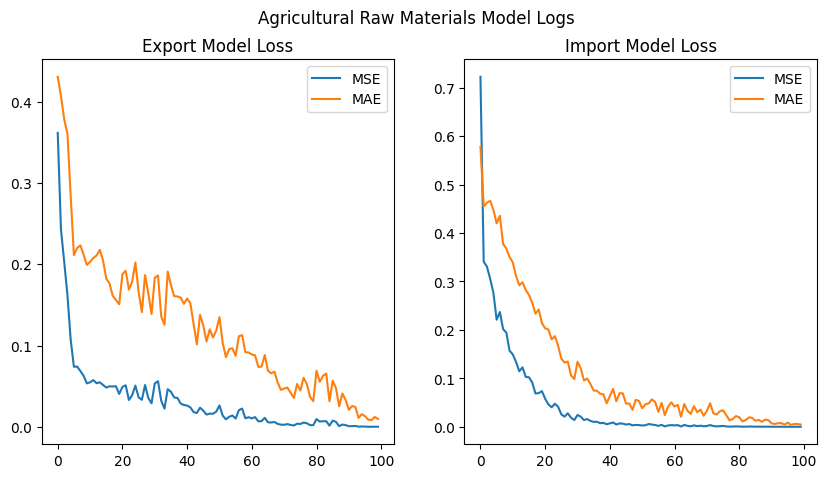

In [8]:
run_ts_model('Agricultural Raw Materials')

................ Training on : Consumer Goods ................
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.5926 - mae: 0.6621
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3014 - mae: 0.4827
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1854 - mae: 0.3319
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1542 - mae: 0.3367
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0847 - mae: 0.2308
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1312 - mae: 0.3315
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1406 - mae: 0.3138
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1227 - mae: 0.2877
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0923 - mae: 0.2473
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0466 - mae: 0.1718
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0653 - mae: 0.2199
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0584 

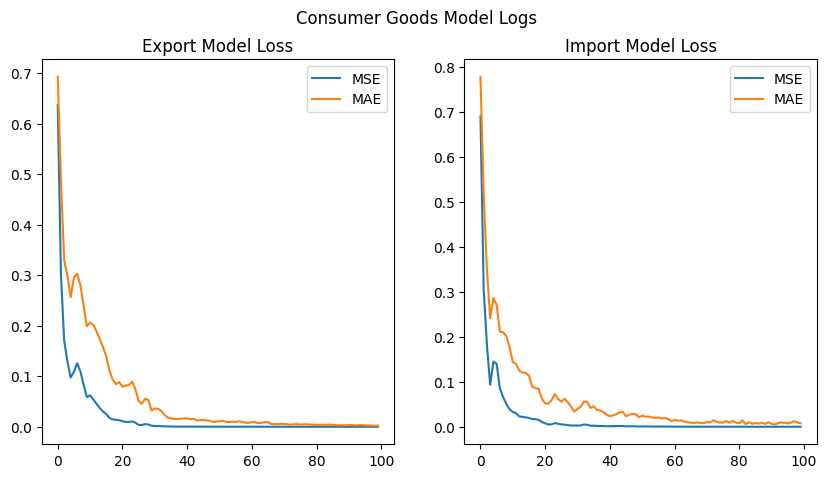

In [9]:
run_ts_model('Consumer Goods')

................ Training on : Transportation ................
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 1.4062 - mae: 0.8095
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.9163 - mae: 0.7285
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7500 - mae: 0.6427
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.9913 - mae: 0.7581
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8408 - mae: 0.6630
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8314 - mae: 0.6958
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5192 - mae: 0.5712
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4658 - mae: 0.5493
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4343 - mae: 0.5316
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3678 - mae: 0.4923
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3983 - mae: 0.5146
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2538 

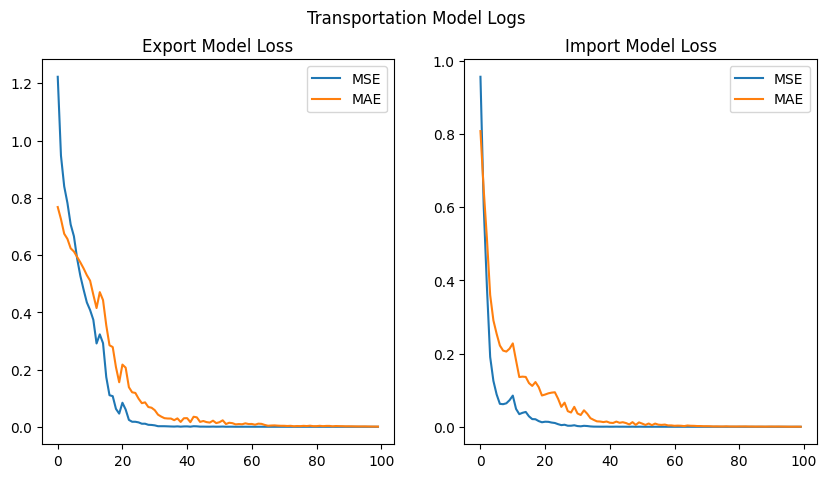

In [10]:
run_ts_model('Transportation')

................ Training on : Food Industry ................
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 1.0470 - mae: 0.6983
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2357 - mae: 0.3800
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1343 - mae: 0.2991
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1174 - mae: 0.2753
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1290 - mae: 0.3108
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0964 - mae: 0.2582
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0993 - mae: 0.2841
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0710 - mae: 0.2425
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0680 - mae: 0.2349
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0639 - mae: 0.2194
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0637 - mae: 0.2118
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0507 -

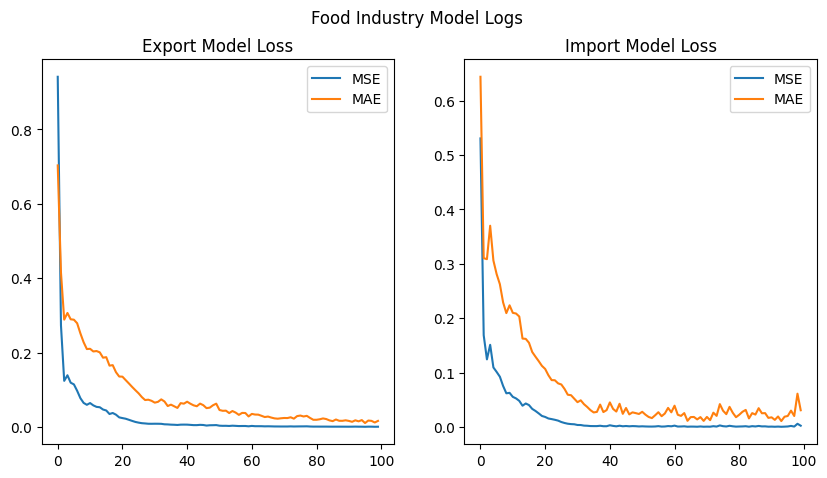

In [11]:
run_ts_model('Food Industry')

................ Training on : Capital Goods ................
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.5850 - mae: 0.6274
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2707 - mae: 0.4481
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3284 - mae: 0.4653
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.3425 - mae: 0.4790
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3254 - mae: 0.4973
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2858 - mae: 0.4224
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2564 - mae: 0.3847
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2014 - mae: 0.3459
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2403 - mae: 0.4002
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2375 - mae: 0.4096
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2023 - mae: 0.3741
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1676 -

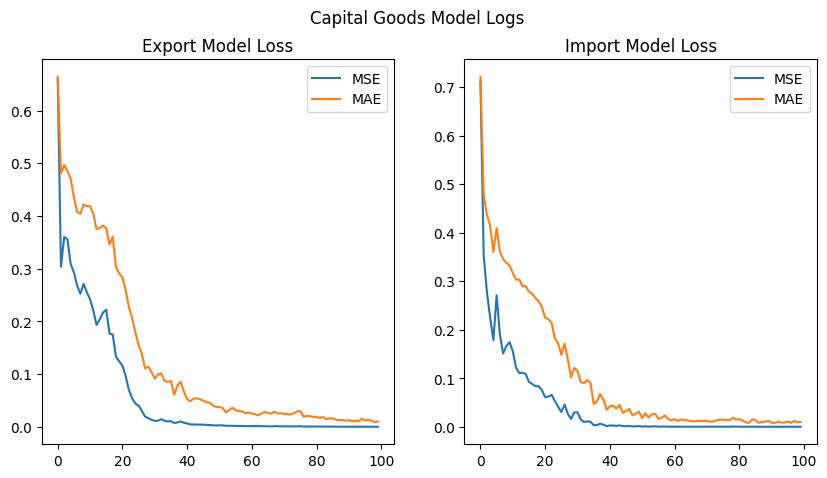

In [12]:
run_ts_model('Capital Goods')

## Inference

In [13]:
industries = [
            'Agricultural Raw Materials',
            'Consumer Goods',
            'Transportation',
            'Food Industry',
            'Capital Goods'
            ]

model_dir = "models/ImpExp/{}"
data_dir = "data/ImpExp/{}"

model_dict = {}

for industry in industries:
    industry_dict = {}
    industry_dict['Imp Model'] = tf.keras.models.load_model(
                                                            model_dir.format(f"{industry} Imp.h5"),
                                                            custom_objects={'mse': 'mse'}
                                                            )
    industry_dict['Exp Model'] = tf.keras.models.load_model(
                                                            model_dir.format(f"{industry} Exp.h5"),
                                                            custom_objects={'mse': 'mse'}
                                                            )
    industry_dict['Scaler'] = pickle.load(open(model_dir.format(f"{industry} Scalar.pickle"), 'rb'))

    model_dict[industry] = industry_dict

In [14]:
def predict_ts_on_industry(
                            industry,
                            selective_window=7
                            ):
    industry_dict = model_dict[industry]
    scaler = industry_dict['Scaler']
    imp_model = industry_dict['Imp Model']
    exp_model = industry_dict['Exp Model']

    df = load_industry_data(industry)
    df_tail = df.tail(selective_window)

    x = df_tail.values
    x = x.reshape(1, x.shape[0], x.shape[1])

    p_imp = imp_model.predict(x).squeeze()
    p_imp = np.vstack([p_imp]*selective_window).squeeze()
    p_imp = np.dstack([p_imp]*selective_window).squeeze()
    p_imp = scaler.inverse_transform(p_imp)
    p_imp = p_imp[0][0]

    p_exp = exp_model.predict(x).squeeze()
    p_exp = np.vstack([p_exp]*selective_window).squeeze()
    p_exp = np.dstack([p_exp]*selective_window).squeeze()
    p_exp = scaler.inverse_transform(p_exp)
    p_exp = p_exp[0][0]

    df_tail_inv = scaler.inverse_transform(df_tail)
    imp_data = df_tail_inv[:, 0]
    exp_data = df_tail_inv[:, 1]

    avg_imp = np.mean(imp_data)
    avg_exp = np.mean(exp_data)

    # percentage of change
    p_imp = ((p_imp - avg_imp) / avg_imp) * 100
    p_exp = ((p_exp - avg_exp) / avg_exp) * 100

    return p_imp, p_exp

In [15]:
p_imp, p_exp = predict_ts_on_industry('Agricultural Raw Materials')

print(f"Predicted Export Change : {p_exp:.2f}%")
print(f"Predicted Import Change : {p_imp:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
Predicted Export Change : 14.94%
Predicted Import Change : 10.53%


In [16]:
p_imp, p_exp = predict_ts_on_industry('Consumer Goods')

print(f"Predicted Export Change : {p_exp:.2f}%")
print(f"Predicted Import Change : {p_imp:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
Predicted Export Change : 41.34%
Predicted Import Change : 8.21%


In [17]:
p_imp, p_exp = predict_ts_on_industry('Transportation')

print(f"Predicted Export Change : {p_exp:.2f}%")
print(f"Predicted Import Change : {p_imp:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
Predicted Export Change : -94.20%
Predicted Import Change : -43.83%


In [18]:
p_imp, p_exp = predict_ts_on_industry('Food Industry')

print(f"Predicted Export Change : {p_exp:.2f}%")
print(f"Predicted Import Change : {p_imp:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
Predicted Export Change : -31.62%
Predicted Import Change : 78.10%


In [19]:
p_imp, p_exp = predict_ts_on_industry('Capital Goods')

print(f"Predicted Export Change : {p_exp:.2f}%")
print(f"Predicted Import Change : {p_imp:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
Predicted Export Change : -85.01%
Predicted Import Change : -5.70%
